# Optimisation of a Neocortical Layer 5 Pyramidal Cell

This notebook shows you how to optimise the maximal conductance of Neocortical Layer 5 Pyramidal Cell as used in Markram et al. 2015.

Author of this script: Werner Van Geit @ Blue Brain Project

Choice of parameters, protocols and other settings was done by Etay Hay @ HUJI

What's described here is a more advanced use of BluePyOpt. We suggest to first go through the introductary example here: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/simplecell/simplecell.ipynb

**If you use the methods in this notebook, we ask you to cite the following publications when publishing your research:**

Van Geit, W., M. Gevaert, G. Chindemi, C. Rössert, J.-D. Courcol, E. Muller, F. Schürmann, I. Segev, and H. Markram (2016, March). BluePyOpt: Leveraging open source software and cloud infrastructure to optimise model parameters in neuroscience. ArXiv e-prints.
http://arxiv.org/abs/1603.00500

Markram, H., E. Muller, S. Ramaswamy, M. W. Reimann, M. Abdellah, C. A. Sanchez, A. Ailamaki, L. Alonso-Nanclares, N. Antille, S. Arsever, et al. (2015). Reconstruction and simulation of neocortical microcircuitry. Cell 163(2), 456–492.
http://www.cell.com/abstract/S0092-8674%2815%2901191-5

Some of the modules loaded in this script are located in the L5PC example folder: https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc 

We first load the bluepyopt python module, the ephys submodule and some helper functionality

In [1]:
%load_ext autoreload
%autoreload

!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)
import matplotlib.pyplot as plt

/gpfs/bbp.cscs.ch/home/damart/BluePyOpt/examples/l5pc
mechanisms/CaDynamics_E2.mod mechanisms/Ca_HVA.mod mechanisms/Ca_LVAst.mod mechanisms/Ih.mod mechanisms/Im.mod mechanisms/K_Pst.mod mechanisms/K_Tst.mod mechanisms/Nap_Et2.mod mechanisms/NaTa_t.mod mechanisms/NaTs2_t.mod mechanisms/ProbAMPANMDA_EMS.mod mechanisms/ProbGABAAB_EMS.mod mechanisms/SK_E2.mod mechanisms/SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod Nap_Et2.mod NaTa_t.mod NaTs2_t.mod ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod SK_E2.mod SKv3_1.mod
"/gpfs/bbp.cscs.ch/project/proj37/software/bb5/local-20191220111427/nrnpython/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/gpfs/bbp.cscs.ch/project/proj37/software/bb5/local-20191220111427/nrnpython/include/nrn" -I"/gpfs/bbp.cscs.ch/project/proj37/software/bb5/local-20191220111427/nrnpython/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/gpfs/bbp.cscs.ch/project/pro

Enable the code below to enable debug level logging

In [2]:
# import logging                                                                      
# logging.basicConfig()                                                               
# logger = logging.getLogger()                                                        
# logger.setLevel(logging.DEBUG)   

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software:

/gpfs/bbp.cscs.ch/project/proj37/software/bb5/local-20191220111427/pyenv/versions/3.7.4/lib/python3.7/site-packages/neurom/io/neurolucida.py:269: UserWarning: This is an experimental reader. There are no guarantees regarding ability to parse Neurolucida .asc files or correctness of output.
  warnings.warn(msg)


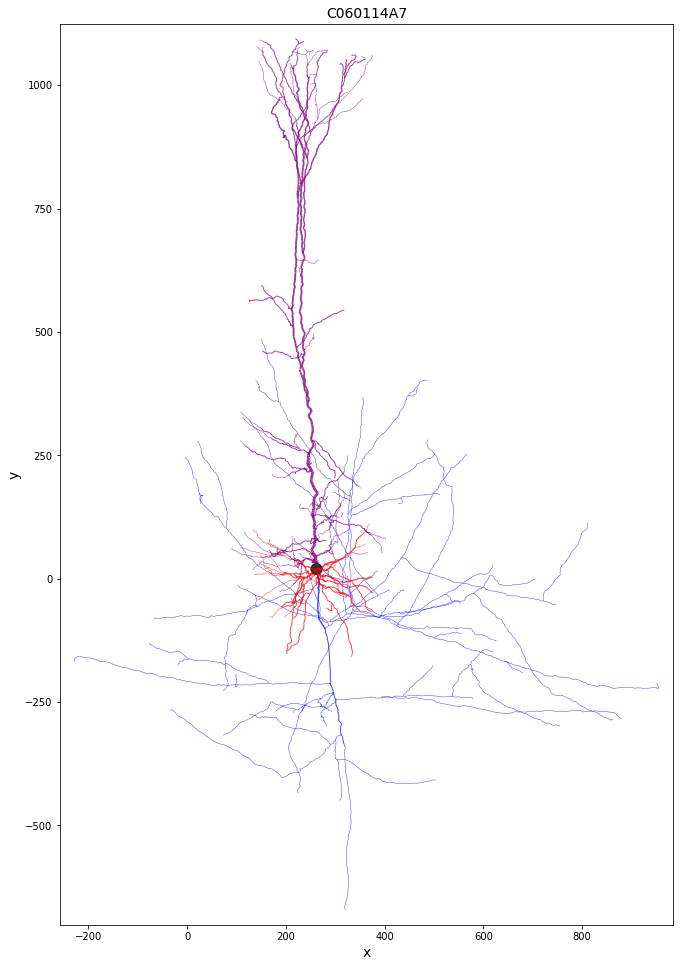

In [12]:
import neurom.viewer
import matplotlib
matplotlib.rcParams['figure.figsize'] = [11, 17]
neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));
matplotlib.pyplot.savefig("l5pc.svg", dpi=200)

To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a AIS.

In [4]:
morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
print(str(morphology))

morphology/C060114A7.asc


### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [5]:
import json
param_configs = json.load(open('config/parameters.json'))
print([param_config['param_name'] for param_config in param_configs])

['g_pas', 'e_pas', 'cm', 'Ra', 'v_init', 'celsius', 'ena', 'ek', 'cm', 'ena', 'ek', 'cm', 'ena', 'ek', 'gIhbar_Ih', 'gNaTs2_tbar_NaTs2_t', 'gSKv3_1bar_SKv3_1', 'gImbar_Im', 'gIhbar_Ih', 'gNaTa_tbar_NaTa_t', 'gNap_Et2bar_Nap_Et2', 'gK_Pstbar_K_Pst', 'gK_Tstbar_K_Tst', 'gSK_E2bar_SK_E2', 'gSKv3_1bar_SKv3_1', 'gCa_HVAbar_Ca_HVA', 'gCa_LVAstbar_Ca_LVAst', 'gamma_CaDynamics_E2', 'decay_CaDynamics_E2', 'gNaTs2_tbar_NaTs2_t', 'gSKv3_1bar_SKv3_1', 'gSK_E2bar_SK_E2', 'gCa_HVAbar_Ca_HVA', 'gCa_LVAstbar_Ca_LVAst', 'gamma_CaDynamics_E2', 'decay_CaDynamics_E2', 'gIhbar_Ih']


The directory that contains this notebook has a module that will load all the parameters in BluePyOpt Parameter objects

In [6]:
import l5pc_model
parameters = l5pc_model.define_parameters()
print('\n'.join('%s' % param for param in parameters))

g_pas.all: ['all'] g_pas = 3e-05
e_pas.all: ['all'] e_pas = -75
cm.all: ['all'] cm = 1
Ra.all: ['all'] Ra = 100
v_init: v_init = -65
celsius: celsius = 34
ena.apical: ['apical'] ena = 50
ek.apical: ['apical'] ek = -85
cm.apical: ['apical'] cm = 2
ena.somatic: ['somatic'] ena = 50
ek.somatic: ['somatic'] ek = -85
cm.basal: ['basal'] cm = 2
ena.axonal: ['axonal'] ena = 50
ek.axonal: ['axonal'] ek = -85
gIhbar_Ih.basal: ['basal'] gIhbar_Ih = 8e-05
gNaTs2_tbar_NaTs2_t.apical: ['apical'] gNaTs2_tbar_NaTs2_t = [0, 0.04]
gSKv3_1bar_SKv3_1.apical: ['apical'] gSKv3_1bar_SKv3_1 = [0, 0.04]
gImbar_Im.apical: ['apical'] gImbar_Im = [0, 0.001]
gIhbar_Ih.apical: ['apical'] gIhbar_Ih = 8e-05
gNaTa_tbar_NaTa_t.axonal: ['axonal'] gNaTa_tbar_NaTa_t = [0, 4]
gNap_Et2bar_Nap_Et2.axonal: ['axonal'] gNap_Et2bar_Nap_Et2 = [0, 4]
gK_Pstbar_K_Pst.axonal: ['axonal'] gK_Pstbar_K_Pst = [0, 1]
gK_Tstbar_K_Tst.axonal: ['axonal'] gK_Tstbar_K_Tst = [0, 0.1]
gSK_E2bar_SK_E2.axonal: ['axonal'] gSK_E2bar_SK_E2 = [0, 0.1

As you can see there are two types of parameters, parameters with a fixed value and parameters with bounds. The latter will be optimised by the algorithm.

### Mechanism

We also need to add all the necessary mechanisms, like ion channels to the model. 
The configuration of the mechanisms is also stored in a json file, and can be loaded in a similar way.

In [7]:
mechanisms = l5pc_model.define_mechanisms()
print('\n'.join('%s' % mech for mech in mechanisms))

Ih.basal: Ih at ['basal']
pas.all: pas at ['all']
Ih.apical: Ih at ['apical']
Im.apical: Im at ['apical']
SKv3_1.apical: SKv3_1 at ['apical']
NaTs2_t.apical: NaTs2_t at ['apical']
Ca_LVAst.axonal: Ca_LVAst at ['axonal']
Ca_HVA.axonal: Ca_HVA at ['axonal']
CaDynamics_E2.axonal: CaDynamics_E2 at ['axonal']
SKv3_1.axonal: SKv3_1 at ['axonal']
SK_E2.axonal: SK_E2 at ['axonal']
K_Tst.axonal: K_Tst at ['axonal']
K_Pst.axonal: K_Pst at ['axonal']
Nap_Et2.axonal: Nap_Et2 at ['axonal']
NaTa_t.axonal: NaTa_t at ['axonal']
NaTs2_t.somatic: NaTs2_t at ['somatic']
SKv3_1.somatic: SKv3_1 at ['somatic']
SK_E2.somatic: SK_E2 at ['somatic']
CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
Ca_HVA.somatic: Ca_HVA at ['somatic']
Ca_LVAst.somatic: Ca_LVAst at ['somatic']
Ih.somatic: Ih at ['somatic']


# Cell model

With the morphology, mechanisms and parameters we can build the cell model

In [8]:
l5pc_cell = ephys.models.CellModel('l5pc', morph=morphology, mechs=mechanisms, params=parameters)
print(l5pc_cell)

l5pc:
  morphology:
    morphology/C060114A7.asc
  mechanisms:
    Ih.basal: Ih at ['basal']
    pas.all: pas at ['all']
    Ih.apical: Ih at ['apical']
    Im.apical: Im at ['apical']
    SKv3_1.apical: SKv3_1 at ['apical']
    NaTs2_t.apical: NaTs2_t at ['apical']
    Ca_LVAst.axonal: Ca_LVAst at ['axonal']
    Ca_HVA.axonal: Ca_HVA at ['axonal']
    CaDynamics_E2.axonal: CaDynamics_E2 at ['axonal']
    SKv3_1.axonal: SKv3_1 at ['axonal']
    SK_E2.axonal: SK_E2 at ['axonal']
    K_Tst.axonal: K_Tst at ['axonal']
    K_Pst.axonal: K_Pst at ['axonal']
    Nap_Et2.axonal: Nap_Et2 at ['axonal']
    NaTa_t.axonal: NaTa_t at ['axonal']
    NaTs2_t.somatic: NaTs2_t at ['somatic']
    SKv3_1.somatic: SKv3_1 at ['somatic']
    SK_E2.somatic: SK_E2 at ['somatic']
    CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
    Ca_HVA.somatic: Ca_HVA at ['somatic']
    Ca_LVAst.somatic: Ca_LVAst at ['somatic']
    Ih.somatic: Ih at ['somatic']
  params:
    g_pas.all: ['all'] g_pas = 3e-05
    e_pa

For use in the cell evaluator later, we need to make a list of the name of the parameters we are going to optimise.
These are the parameters that are not frozen.

In [9]:
param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [10]:
proto_configs = json.load(open('config/protocols.json'))
print(proto_configs)

{'bAP': {'stimuli': [{'delay': 295, 'amp': 1.9, 'duration': 5, 'totduration': 600}], 'extra_recordings': [{'var': 'v', 'somadistance': 660, 'type': 'somadistance', 'name': 'dend1', 'seclist_name': 'apical'}, {'var': 'v', 'somadistance': 800, 'type': 'somadistance', 'name': 'dend2', 'seclist_name': 'apical'}]}, 'Step3': {'stimuli': [{'delay': 700, 'amp': 0.95, 'duration': 2000, 'totduration': 3000}, {'delay': 0, 'amp': -0.126, 'duration': 3000, 'totduration': 3000}]}, 'Step2': {'stimuli': [{'delay': 700, 'amp': 0.562, 'duration': 2000, 'totduration': 3000}, {'delay': 0, 'amp': -0.126, 'duration': 3000, 'totduration': 3000}]}, 'Step1': {'stimuli': [{'delay': 700, 'amp': 0.458, 'duration': 2000, 'totduration': 3000}, {'delay': 0, 'amp': -0.126, 'duration': 3000, 'totduration': 3000}]}}


And they can be automatically loaded

In [11]:
import l5pc_evaluator
fitness_protocols = l5pc_evaluator.define_protocols()
print('\n'.join('%s' % protocol for protocol in fitness_protocols.values()))

bAP:
  stimuli:
    Square pulse amp 1.900000 delay 295.000000 duration 5.000000 totdur 600.000000 at somatic[0](0.5)
  recordings:
    bAP.soma.v: v at somatic[0](0.5)
    bAP.dend1.v: v at 660.000000 micron from soma in apical
    bAP.dend2.v: v at 800.000000 micron from soma in apical

Step3:
  stimuli:
    Square pulse amp 0.950000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at somatic[0](0.5)
  recordings:
    Step3.soma.v: v at somatic[0](0.5)

Step2:
  stimuli:
    Square pulse amp 0.562000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at somatic[0](0.5)
  recordings:
    Step2.soma.v: v at somatic[0](0.5)

Step1:
  stimuli:
    Square pulse amp 0.458000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp

## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

In [12]:
feature_configs = json.load(open('config/features.json'))
pp.pprint(feature_configs)

{ 'Step1': { 'soma': { 'AHP_depth_abs': [-60.3636, 2.3018],
                       'AHP_depth_abs_slow': [-61.1513, 2.3385],
                       'AHP_slow_time': [0.1599, 0.0483],
                       'AP_height': [25.0141, 3.1463],
                       'AP_width': [3.5312, 0.8592],
                       'ISI_CV': [0.109, 0.1217],
                       'adaptation_index2': [0.0047, 0.0514],
                       'doublet_ISI': [62.75, 9.6667],
                       'mean_frequency': [6, 1.2222],
                       'time_to_first_spike': [27.25, 5.7222]}},
  'Step2': { 'soma': { 'AHP_depth_abs': [-59.9055, 1.8329],
                       'AHP_depth_abs_slow': [-60.2471, 1.8972],
                       'AHP_slow_time': [0.1676, 0.0339],
                       'AP_height': [27.1003, 3.1463],
                       'AP_width': [2.7917, 0.7499],
                       'ISI_CV': [0.0674, 0.075],
                       'adaptation_index2': [0.005, 0.0067],
                     

In [13]:
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)
print(fitness_calculator)

objectives:
  ( AP_width for {'': 'bAP.soma.v'} with stim start 295 and end 600, exp mean 2.0 and std 0.5 and AP threshold override -20 )
  ( AP_height for {'': 'bAP.soma.v'} with stim start 295 and end 600, exp mean 25.0 and std 5.0 and AP threshold override -20 )
  ( Spikecount for {'': 'bAP.soma.v'} with stim start 295 and end 600, exp mean 1.0 and std 0.01 and AP threshold override -20 )
  ( AP_amplitude_from_voltagebase for {'': 'bAP.dend1.v'} with stim start 295 and end 600, exp mean 45 and std 10 and AP threshold override -55 )
  ( AP_amplitude_from_voltagebase for {'': 'bAP.dend2.v'} with stim start 295 and end 600, exp mean 36 and std 9.33 and AP threshold override -55 )
  ( AP_height for {'': 'Step3.soma.v'} with stim start 700 and end 2700, exp mean 19.7207 and std 3.7204 and AP threshold override -20 )
  ( AHP_slow_time for {'': 'Step3.soma.v'} with stim start 700 and end 2700, exp mean 0.1968 and std 0.0112 and AP threshold override -20 )
  ( ISI_CV for {'': 'Step3.soma.v'

## Simulator

We need to define which simulator we will use. In this case it will be Neuron, i.e. the NrnSimulator class

In [14]:
sim = ephys.simulators.NrnSimulator()

/Users/damart/BluePyOpt/bluepyopt/ephys/simulators.py:75: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


## Evaluator

With all the components defined above we can build a cell evaluator

In [15]:
evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

This evaluator can be used to run the protocols. The original parameter values for the Markram et al. 2015 L5PC model are:

In [16]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}


Running the responses is as easy as passing the protocols and parameters to the evaluator. (The line below will take some time to execute)

In [17]:
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=release_params)

We can now plot all the responses

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


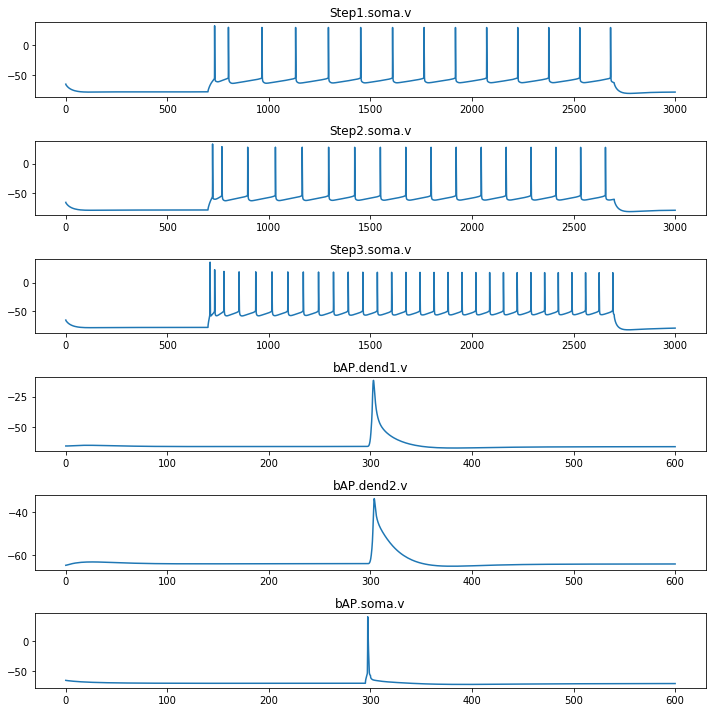

In [18]:
def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()
plot_responses(release_responses)

Running an optimisation of the parameters now has become very easy. 
Of course running the L5PC optimisation will require quite some computing resources. 

To show a proof-of-concept, we will only run 2 generations, with 2 offspring individuals per generations.
If you want to run all full optimisation, you should run for 100 generations with an offspring size of 100 individuals. 

In [ ]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=10) 
final_pop, halloffame, log, hist = opt.run(max_ngen=20, cp_filename='checkpoints/checkpoint.pkl')

The first individual in the hall of fame will contain the best solution found.

In [ ]:
print(halloffame[0])

These are the raw parameter values. 
The evaluator object can convert this in a dictionary, so that we can see the parameter names corresponding to these values.

In [ ]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))

Then we can run the fitness protocols on the model with these parameter values

In [ ]:
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

And then we can also plot these responses. 

When you ran the above optimisation with only 2 individuals and 2 generations, this 'best' model will of course be very low quality.

In [ ]:
plot_responses(best_responses)